## Ejemplo: LogisticRegression

Consideraciones del ejemplo (Usar o no usar segun criterio de cada grupo):

- Elimino outliers con cuantiles
- Elimino todos los nulos
- Escalo todas las variables
- Uso Logistic regression como selector de features
- Uso gridsearchCV

Si van a usar LogisticRegression para armar un modelo base, recomiendo que usen los hiperparametros del modelo que vienen por defecto, ya que solo queremos una primera aproximacion. Dejo en ustedes la desición de usar o no un feature selector en el modelo base. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics

from scipy import linalg
from sklearn import mixture

sns.set_style("darkgrid")

# Obtenemos los datos

df_etiquetados = []
df_no_etiquetados = []
filedir = "data_preprocessed"

from os import listdir

for file in listdir(filedir):
    if file[-4:] == ".csv":
        if "noEtiquetado" in file: df_no_etiquetados.append(pd.read_csv(f"{filedir}/{file}"))
        else: df_etiquetados.append(pd.read_csv(f"{filedir}/{file}"))
    else: print(file, " ---> no es csv")

for df in df_etiquetados: assert len(df.columns) == 11
for df in df_no_etiquetados: assert len(df.columns) == 10
    
df = pd.concat(df_etiquetados)

In [2]:
df

,Patient,State,PE,SC,GNE,SE,LZC,STE,Mean,Std,Skew
0,1.0,1.0,0.598255,0.285388,0.662095,0.520937,0.325380,0.802138,4.426225e-06,15.557899,-0.000629
1,1.0,0.0,0.541613,0.283209,0.570060,0.413078,0.195333,0.752879,2.075434e-05,48.467869,-0.031036
2,1.0,0.0,0.543293,0.283316,0.572859,0.418008,0.199974,0.754335,5.322688e-06,46.771531,-0.077559
3,1.0,0.0,0.535949,0.282724,0.560678,0.391206,0.166309,0.747854,-1.353617e-05,48.590217,-0.024175
4,1.0,0.0,0.436980,0.272283,0.398864,0.412815,0.116037,0.668147,-5.555946e-07,41.749673,-0.087401
...,...,...,...,...,...,...,...,...,...,...,...
2341,2.0,0.0,0.510067,0.283269,0.522142,0.594527,0.300433,0.729515,-1.717178e-05,26.392637,-0.029033
2342,2.0,0.0,0.564873,0.286244,0.610203,0.553031,0.350188,0.774720,1.333844e-05,40.535139,-0.128528
2343,2.0,1.0,0.362519,0.255691,0.271619,0.569788,0.115600,0.612135,-1.032709e-05,21.506041,-0.538919
2344,2.0,0.0,0.570313,0.286206,0.618980,0.576464,0.364877,0.779346,-2.007174e-05,39.010453,-0.223666


### Filtro de outliers

In [3]:
# Aplico un filtro a cada columna y reasigno con el df original.
def outlier_filter(df, c, low, top):
    return df[(df[c] > low) & (df[c] < top)]


# Elimino outliers para cada columna con metodo de cuantiles
for col in df.columns:
    low = df[col].quantile(0.01)
    top = df[col].quantile(0.99)
    dff = outlier_filter(df, col, low, top)
    
# Elimino nulos
dff.dropna(inplace=True)

df = dff
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5849 entries, 0 to 2345
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Patient  5849 non-null   float64
 1   State    5849 non-null   float64
 2   PE       5849 non-null   float64
 3   SC       5849 non-null   float64
 4   GNE      5849 non-null   float64
 5   SE       5849 non-null   float64
 6   LZC      5849 non-null   float64
 7   STE      5849 non-null   float64
 8   Mean     5849 non-null   float64
 9   Std      5849 non-null   float64
 10  Skew     5849 non-null   float64
dtypes: float64(11)
memory usage: 548.3 KB


/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


#### Matriz de resultados

In [22]:
cla_results = pd.DataFrame(index=['Accuracy Train', 'Accuracy Valid', 'Precision Train', 'Precision Valid', 
                                  'Recall Train', 'Recall Valid', 'F1-score Train', 'F1-score Valid'])

In [23]:
# Separamos features de etiqueta
X = df.drop(labels=['State','Patient'], axis=1)
y = df['State']

In [24]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=0, shuffle=False)

In [25]:
# Preproceso 1 para XGBClassifier - Default
scaler = MaxAbsScaler()
ft_selector = LogisticRegression(random_state=0, penalty='l1', solver='liblinear')

param_grid = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__random_state': [0],
    'classifier__solver': ['liblinear'],
    'classifier__class_weight': ['balanced']
}


model_ = LogisticRegression(random_state= 0)

In [26]:
# Fit
pipe = Pipeline([
  ('scaler', scaler),
  ('feature_selection', SelectFromModel(ft_selector)),
  ('classifier', model_)
])

model = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error',cv=5)

model.fit(X_train, y_train)
svr_cv = model

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


#### Preproceso y ajuste

In [27]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

#### Evaluacion de predicciones

LogisticRegression - Reporte de clasificación del conjunto de train
              precision    recall  f1-score   support

         0.0       0.96      0.67      0.79      3774
         1.0       0.14      0.64      0.23       320

    accuracy                           0.67      4094
   macro avg       0.55      0.66      0.51      4094
weighted avg       0.89      0.67      0.75      4094

LogisticRegression - Reporte de clasificación del conjunto de validacion
              precision    recall  f1-score   support

         0.0       0.95      0.42      0.58      1653
         1.0       0.06      0.63      0.11       102

    accuracy                           0.43      1755
   macro avg       0.51      0.53      0.35      1755
weighted avg       0.90      0.43      0.56      1755



Text(0.5, 1.0, 'LogisticRegression - CM Valid\n')

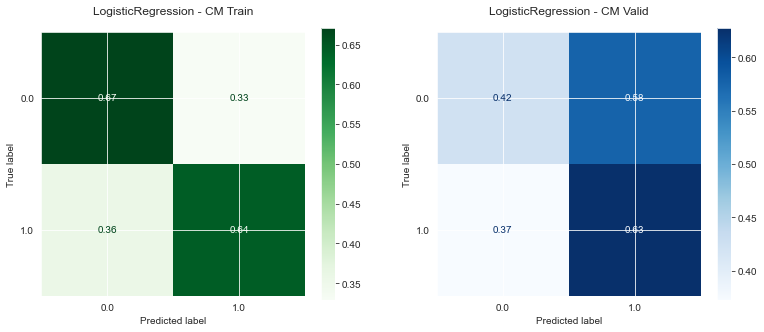

In [29]:
# Evaluate train
text = "LogisticRegression - Reporte de clasificación del conjunto de train" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(metrics.classification_report(y_train, y_train_pred))

# Evaluate val
print(len(text)*"=")
print("LogisticRegression - Reporte de clasificación del conjunto de validacion")
print(len(text)*"=")
print(metrics.classification_report(y_val, y_valid_pred))

fig, axes = plt.subplots(1,2, figsize=(13,5))

metrics.plot_confusion_matrix(ax=axes[0], estimator= model, X=X_train, y_true=y_train,
                      normalize='true', cmap='Greens').ax_ \
                      .set_title('LogisticRegression - CM Train\n')

metrics.plot_confusion_matrix(ax=axes[1], estimator= model, X=X_val, y_true=y_val,
                      normalize='true', cmap='Blues').ax_ \
                      .set_title('LogisticRegression - CM Valid\n')

#### Matriz de resultados

In [30]:
cla_results['LogisticRegression'] = [metrics.accuracy_score(y_train, y_train_pred), metrics.accuracy_score(y_val, y_valid_pred),
                                         metrics.precision_score(y_train, y_train_pred), metrics.precision_score(y_val, y_valid_pred),
                                         metrics.recall_score(y_train, y_train_pred), metrics.recall_score(y_val, y_valid_pred),
                                         metrics.f1_score(y_train, y_train_pred), metrics.f1_score(y_val, y_valid_pred)]      

In [31]:
cla_results

,LogisticRegression
Accuracy Train,0.668784
Accuracy Valid,0.434758
Precision Train,0.142265
Precision Valid,0.062868
Recall Train,0.643750
Recall Valid,0.627451
F1-score Train,0.233032
F1-score Valid,0.114286
